In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from nltk.stem.snowball import SnowballStemmer
from sklearn.manifold import TSNE

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

con = sqlite3.connect('database.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print(data.shape)

(525814, 10)


In [2]:
data['Score'] = data['Score'].map(lambda x: "negative" if x<3 else "positive")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Sort the reviews in Ascending Order by the 'ProductId'
data = data.sort_values('ProductId')
data = data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'})
data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]
data.shape

(364171, 10)

In [4]:
data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [5]:
positives = data[data['Score'] == 'positive'].iloc[:2000]
negatives = data[data['Score'] == 'negative'].iloc[:2000]
data = pd.concat([positives, negatives])
print(data.shape)

(4000, 10)


In [6]:
#data.head()
#data.tail()
#data.iloc[0]['Text']
data['Text'].values[0]

"this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college"

In [7]:
data['Score'].value_counts()

positive    2000
negative    2000
Name: Score, dtype: int64

In [8]:
stops = set(stopwords.words('english')) - set(['not'])
snow = SnowballStemmer('english')

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|:|#]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

filtered_reviews = []
s = ''

for review in data['Text'].values:
    filtered_sent = []
    review = cleanhtml(review)
    review = cleanpunc(review)
    for word in review.split():
        if word.isalpha() and len(word) > 2:
            if word.lower() not in stops:
                s = snow.stem(word.lower()).encode('utf8')
                filtered_sent.append(s)
    filtered_reviews.append(b' '.join(filtered_sent))

print(filtered_reviews[:2])
print(len(filtered_reviews))

[b'witti littl book make son laugh loud recit car drive along alway sing refrain learn whale india droop rose love new word book introduc silli classic book will bet son still abl recit memori colleg', b'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open']
4000


In [9]:
data['CleanedText'] = filtered_reviews
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [10]:
def run_tsne(vect, labels):
    model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=8000, verbose=1)
    tsne_data = model.fit_transform(vect)

    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    tsne_df.head()

    sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.show()

(4000, 9547)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 2.970s...
[t-SNE] Computed neighbors for 4000 samples in 326.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 1.462700
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.278755
[t-SNE] Error after 3200 iterations: 2.656337


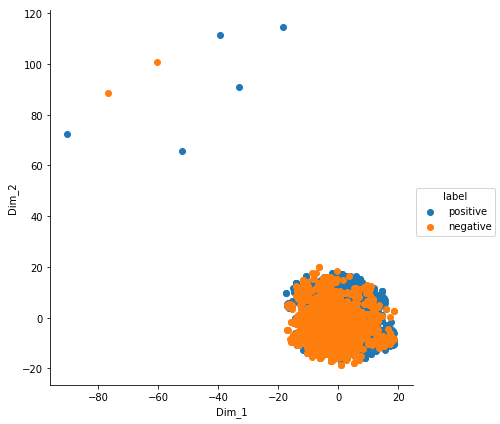

Wall time: 15min 27s


In [23]:
%%time
bow_counts = CountVectorizer().fit_transform(data['CleanedText'].values).toarray()
print(bow_counts.shape)

# TSNE using BOW Vectors
run_tsne(bow_counts, data['Score'].values)

(4000, 9547)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 2.187s...
[t-SNE] Computed neighbors for 4000 samples in 302.938s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.290163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.004486
[t-SNE] Error after 8000 iterations: 1.816814


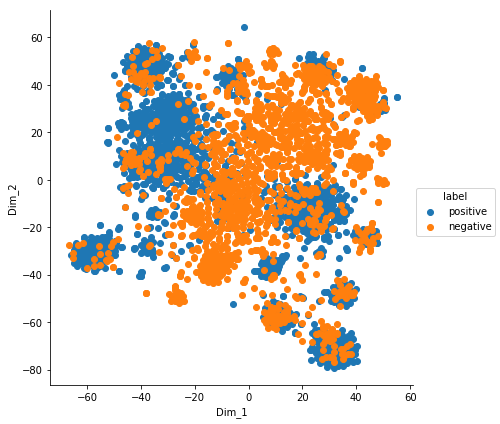

Wall time: 23min 27s


In [24]:
%%time
tfidf_vect = TfidfVectorizer().fit_transform(data['CleanedText'].values).toarray()
print(tfidf_vect.shape)

# TSNE using TF-IDF Vectors
run_tsne(tfidf_vect, data['Score'].values)

4000
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.016s...
[t-SNE] Computed neighbors for 4000 samples in 1.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.063247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.548767
[t-SNE] Error after 8000 iterations: 1.160664


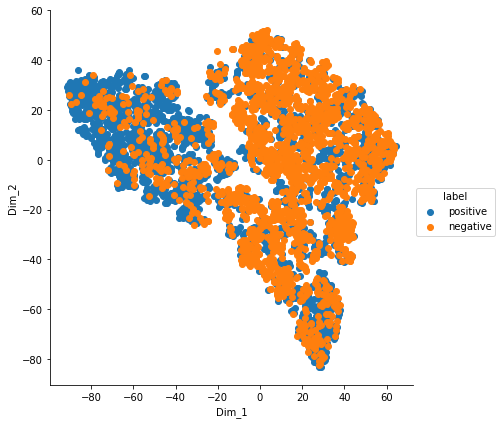

Wall time: 17min 42s


In [16]:
%%time
list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

w2v_model = Word2Vec(list_of_sent, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            count_words += 1
    if count_words != 0:
        sent_vec /= count_words
    sent_vectors.append(sent_vec)

print(len(sent_vectors))

# TSNE using Avg. W2V Vectors
run_tsne(sent_vectors, data['Score'].values)

4000
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.011s...
[t-SNE] Computed neighbors for 4000 samples in 0.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.072283
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.372963
[t-SNE] Error after 8000 iterations: 1.076549


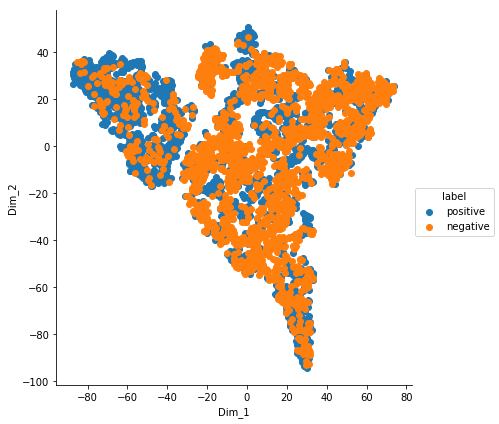

Wall time: 17min 37s


In [19]:
%%time
tfidf = TfidfVectorizer()
tfidf_vect = tfidf.fit_transform(data['CleanedText'].values).toarray()
tfidf_feat = tfidf.get_feature_names()

tfidf_sent_vectors = []
row=0

list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = tfidf_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weighted_sum += tf_idf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

print(len(tfidf_sent_vectors))

# TSNE using TF-IDF weighted W2V Vectors
run_tsne(tfidf_sent_vectors, data['Score'].values)

In [18]:
def run_tsne(vect, labels):
    model = TSNE(n_components=2, random_state=0, perplexity=75,  n_iter=8000, verbose=1)
    tsne_data = model.fit_transform(vect)

    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    tsne_df.head()

    sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.show()

4000
[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.014s...
[t-SNE] Computed neighbors for 4000 samples in 1.430s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.076202
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.696350
[t-SNE] Error after 7000 iterations: 1.024179


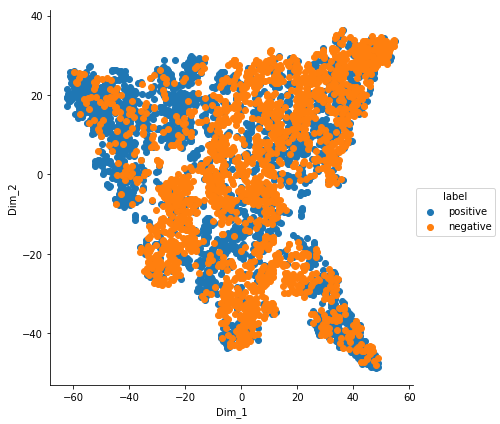

Wall time: 22min 36s


In [19]:
%%time
tfidf = TfidfVectorizer()
tfidf_vect = tfidf.fit_transform(data['CleanedText'].values).toarray()
tfidf_feat = tfidf.get_feature_names()

tfidf_sent_vectors = []
row=0

list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

w2v_model = Word2Vec(list_of_sent, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = tfidf_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weighted_sum += tf_idf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

print(len(tfidf_sent_vectors))

# TSNE using TF-IDF weighted W2V Vectors
run_tsne(tfidf_sent_vectors, data['Score'].values)